In [1]:
import os
import cv2
import numpy as np
import pytesseract
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from skimage.filters import threshold_local
import re
import datasets
from datasets import load_dataset
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D
import torch
import torch.nn as nn
import pytorch_lightning as pl
from transformers import AutoModel
from transformers import LayoutLMv3Processor
from torchvision.transforms import ToPILImage

## Step : 1 Data Preprocessing

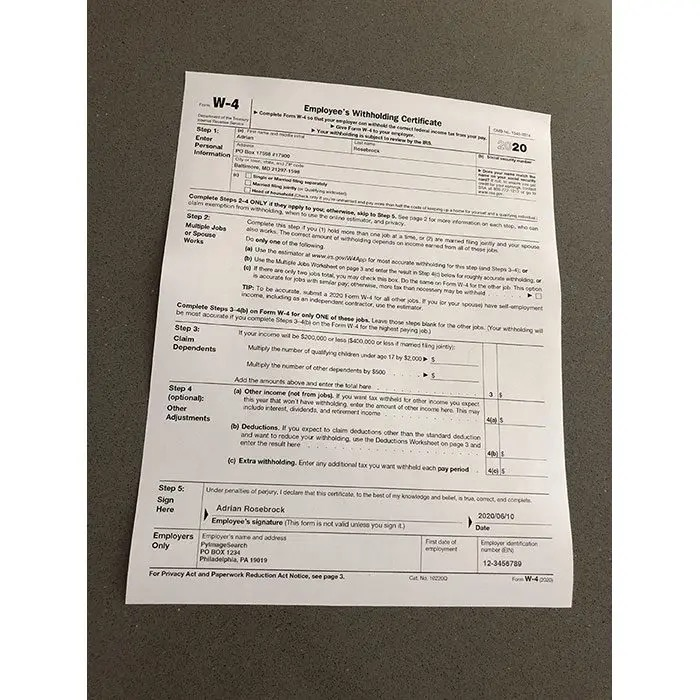

In [2]:
image = Image.open("./inference_data/sample.jpeg")
image.thumbnail((800,800), Image.LANCZOS)
image

In [3]:

def resize_image(image, ratio):
    dim = (int(image.shape[1] * ratio), int(image.shape[0] * ratio))
    return cv2.resize(image, dim, interpolation=cv2.INTER_AREA)

def plot_gray_image(image):
    plt.figure(figsize=(16, 10))
    plt.imshow(image, cmap='gray')
    plt.show()

def plot_rgb_image(image):
    plt.figure(figsize=(16, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

def approximate_contour(contour):
    perimeter = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * perimeter, True)

def get_form_contour(contours):    
    for contour in contours:
        approx = approximate_contour(contour)
        if len(approx) == 4:
            return approx

def contour_to_rect(contour, resize_ratio):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio

def wrap_perspective(img, rect):
    (tl, tr, br, bl) = rect
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

def black_white_scanner(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray, 21, offset=5, method="gaussian")
    return (gray > T).astype("uint8") * 255

def find_amounts(text):
    amounts = re.findall(r'\d+\.\d{2}\b', text)
    floats = [float(amount) for amount in amounts]
    unique = list(dict.fromkeys(floats))
    return unique

def plot_gray_image(image):
    plt.figure(figsize=(16,10))
    plt.imshow(image, cmap='Greys_r')
    plt.show()

def plot_rgb_image(image):
    plt.figure(figsize=(16,10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt


In [4]:
image = np.array(image)
resize_ratio = 500 / image.shape[0]
original = image.copy()
image = resize_image(image, resize_ratio)

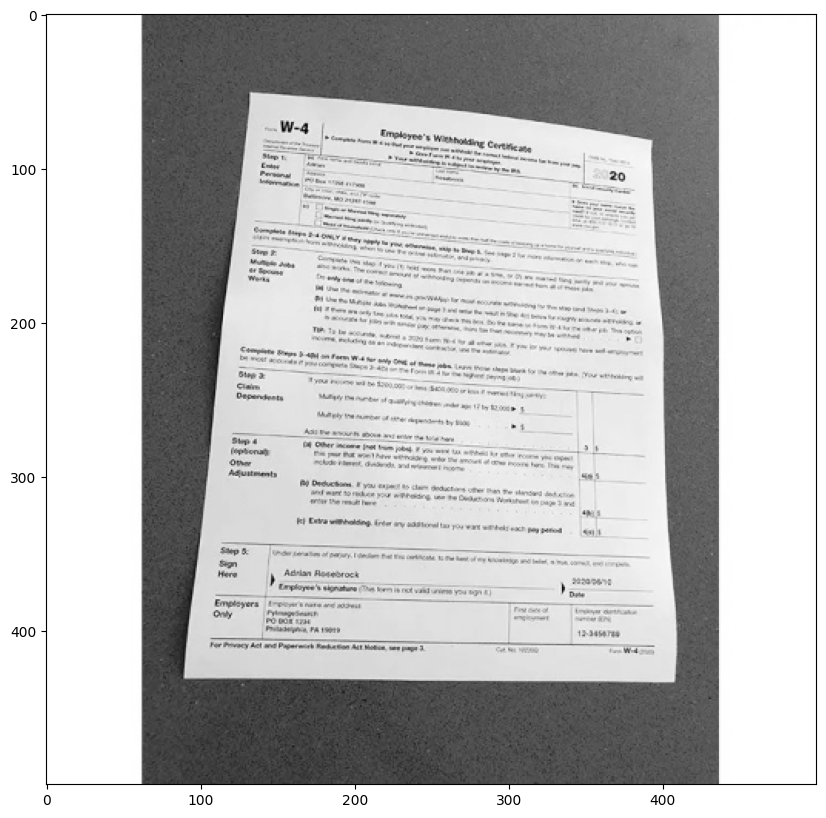

In [5]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plot_gray_image(gray)

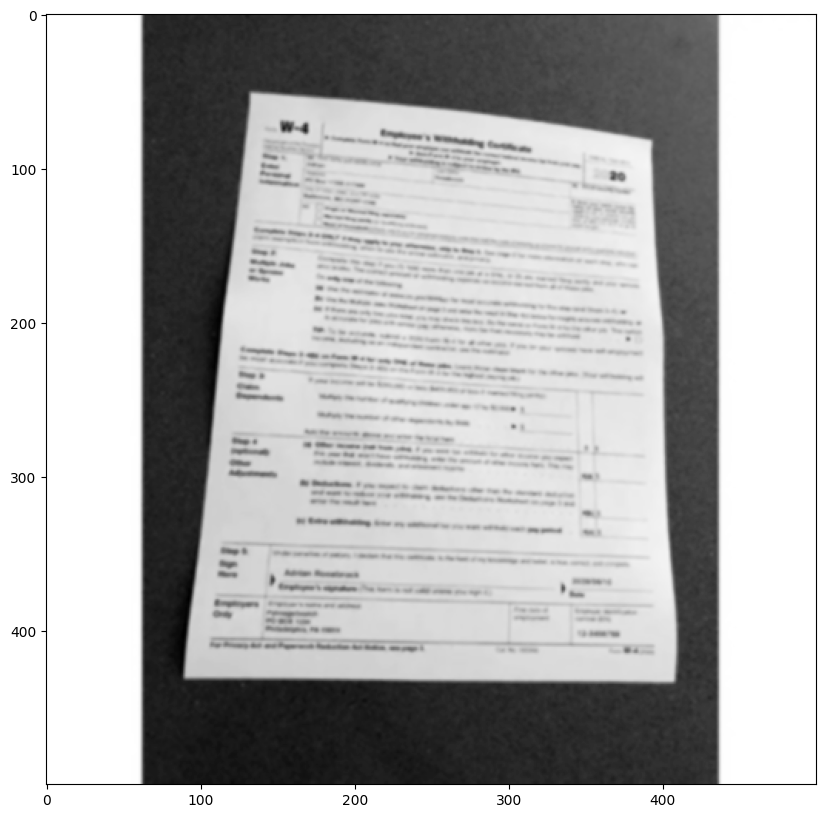

In [6]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plot_gray_image(blurred)

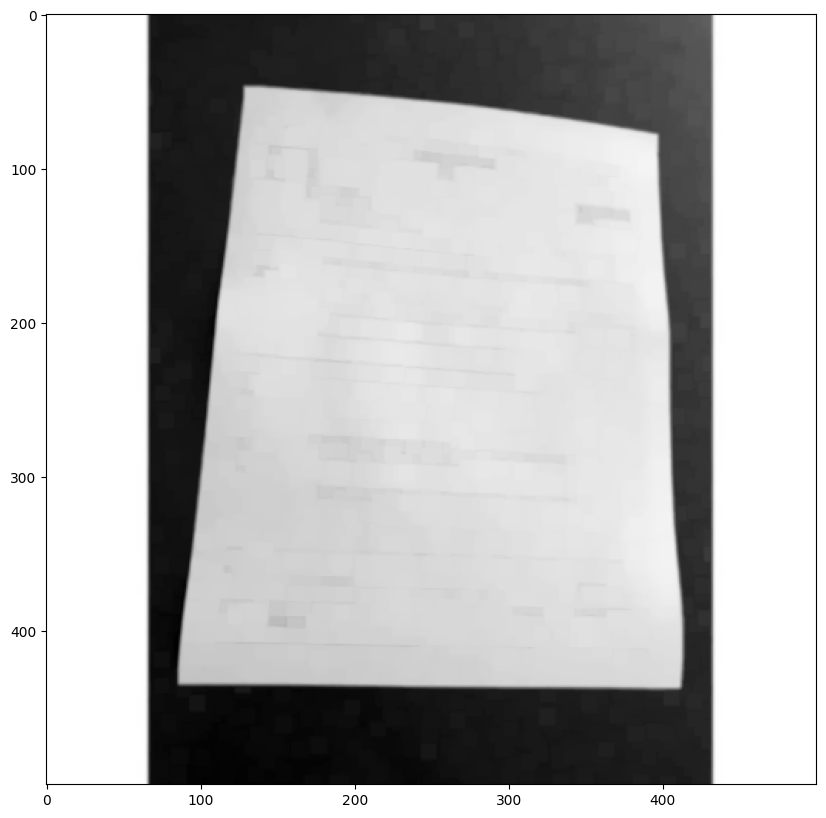

In [7]:
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
dilated = cv2.dilate(blurred, rectKernel)
plot_gray_image(dilated)

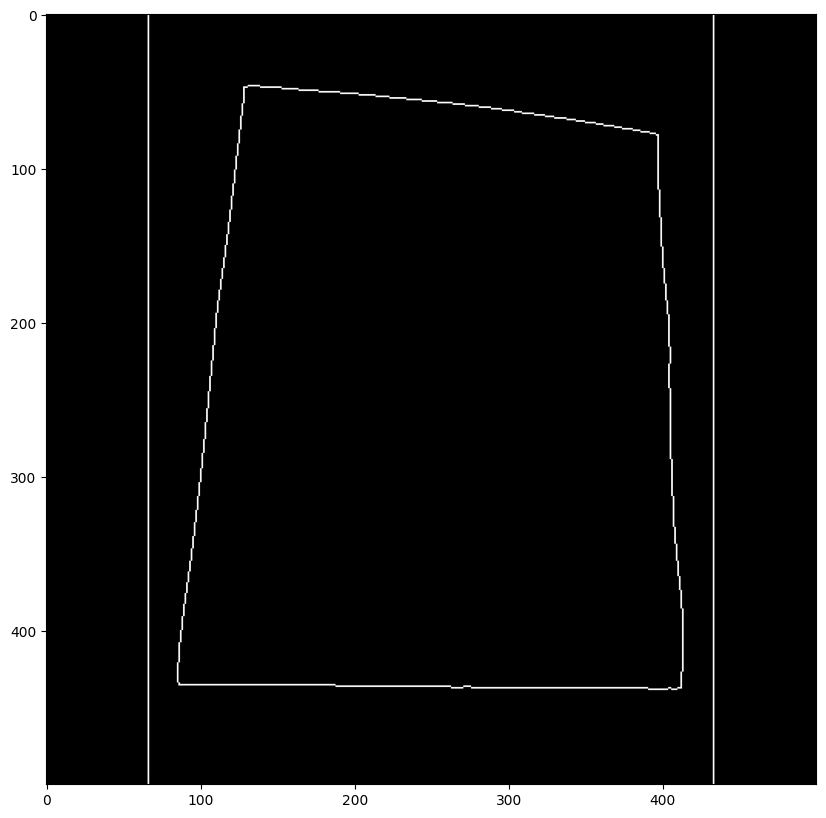

In [8]:
edged = cv2.Canny(dilated, 50, 125, apertureSize=3)
plot_gray_image(edged)

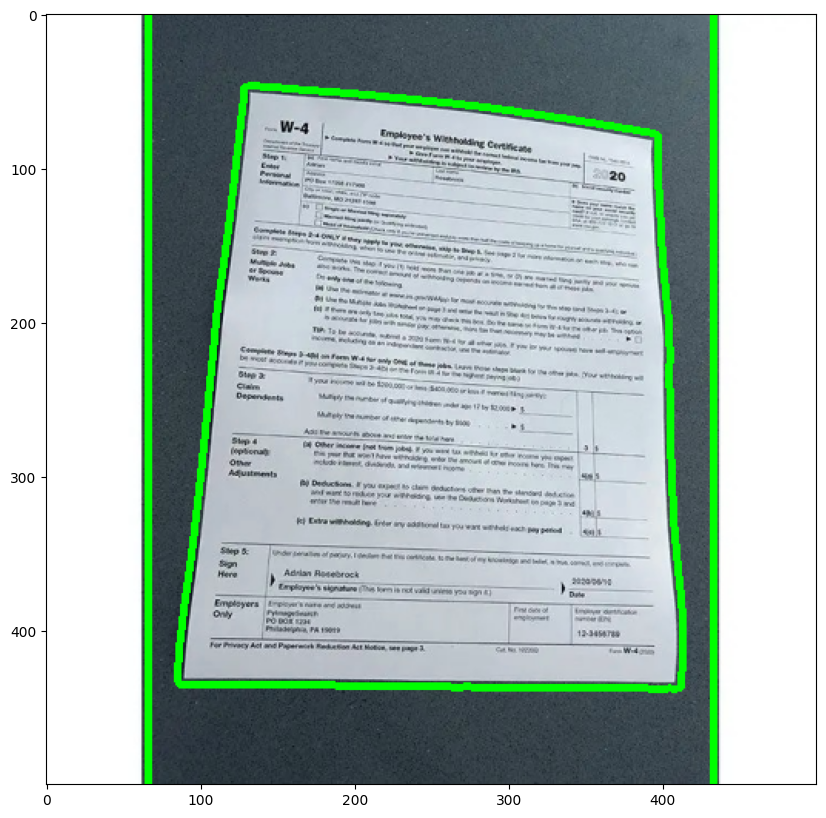

In [9]:
contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
plot_rgb_image(image_with_contours)

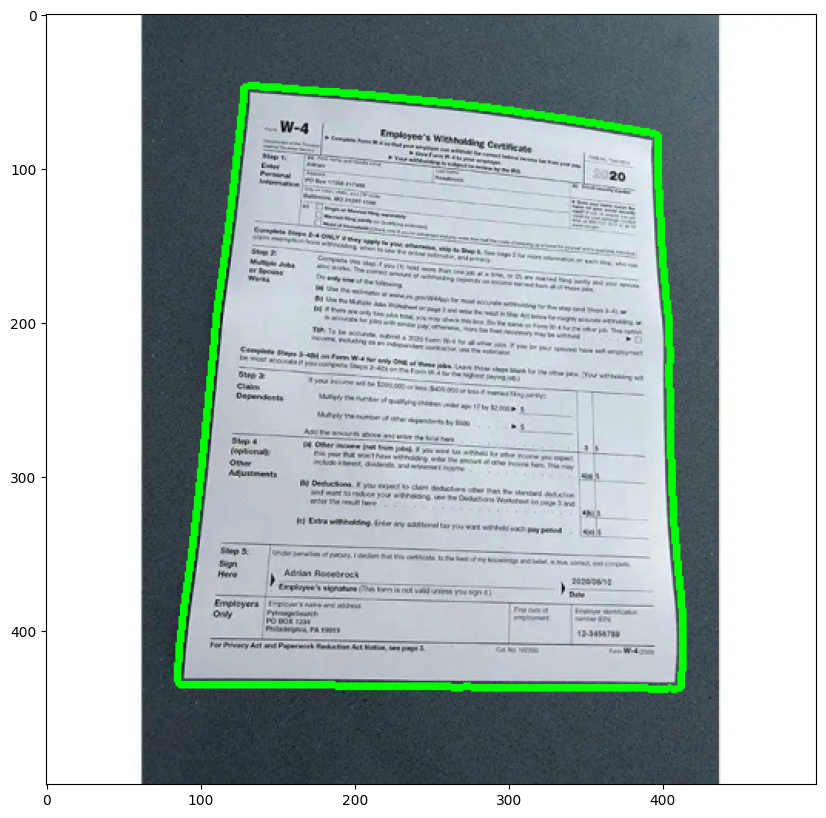

In [10]:
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:1]
image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
plot_rgb_image(image_with_largest_contours)

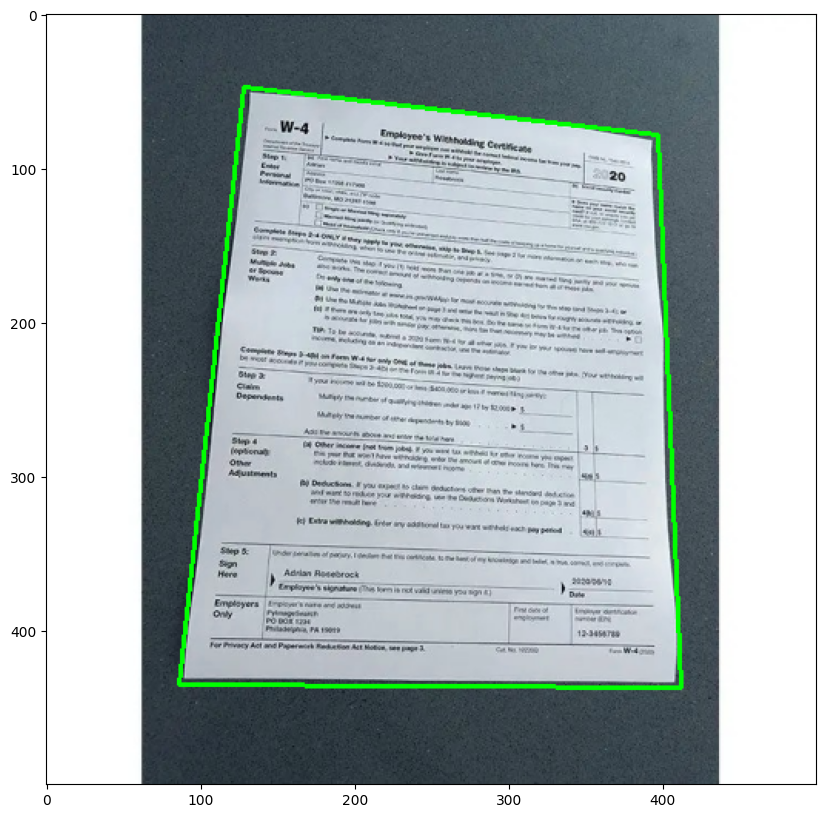

In [11]:
form_contour = get_form_contour(largest_contours)
image_with_form_contour = cv2.drawContours(image.copy(), [form_contour], -1, (0, 255, 0), 2)
plot_rgb_image(image_with_form_contour)

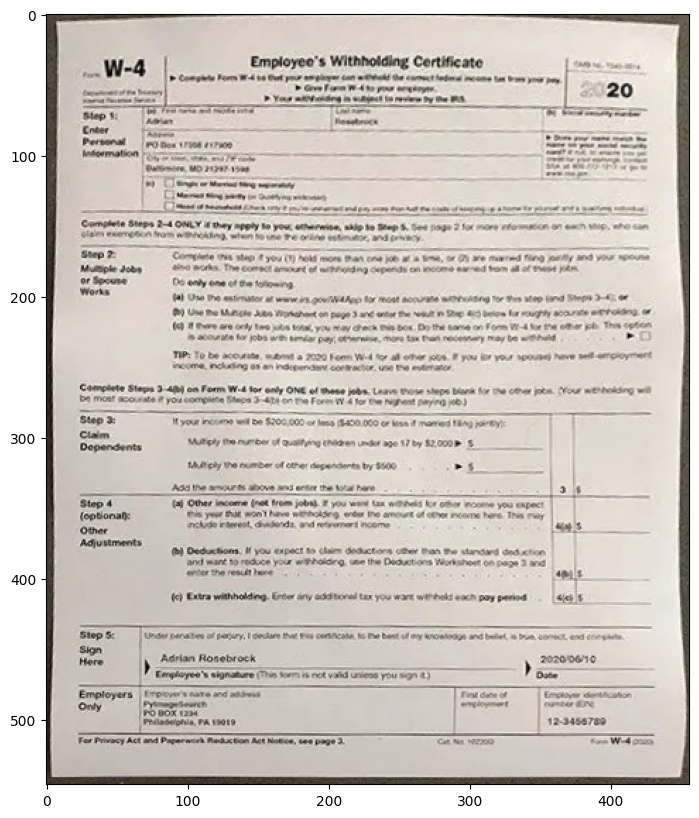

In [12]:
scanned = wrap_perspective(original.copy(), contour_to_rect(form_contour,resize_ratio))
plt.figure(figsize=(16,10))
plt.imshow(scanned)

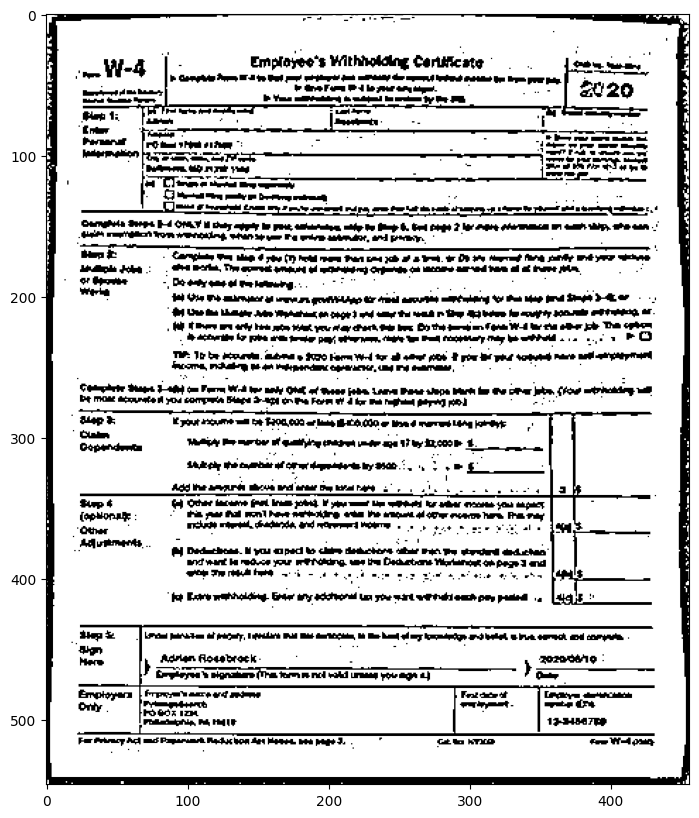

In [13]:
result = black_white_scanner(scanned)
plot_gray_image(result)

## Step  : 2 Extracting and Preparing data for inference

### Preparing data in specific Format

In [14]:
dataset = load_dataset("nielsr/funsd-layoutlmv3")

Found cached dataset funsd-layoutlmv3 (C:/Users/15148/.cache/huggingface/datasets/nielsr___funsd-layoutlmv3/funsd/1.0.0/0e3f4efdfd59aa1c3b4952c517894f7b1fc4d75c12ef01bcc8626a69e41c1bb9)


  0%|          | 0/2 [00:00<?, ?it/s]

In [15]:
labels = dataset["test"].features["ner_tags"].feature.names
id2label = {v: k for v, k in enumerate(labels)}
id2label1 = {0: 'Other', 1: 'HEADER', 2: 'HEADER', 3: 'QUESTION', 4: 'QUESTION', 5: 'ANSWER', 6: 'ANSWER'}

In [16]:
column_names = dataset["test"].column_names
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

In [17]:
processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base",apply_ocr=False)
def prepare_dataset(sample):
    img = [item["image"] for item in sample] if isinstance(sample, list) else sample["image"]
    tokens = [item["tokens"] for item in sample] if isinstance(sample, list) else sample["tokens"]
    bbox = [item["bboxes"] for item in sample] if isinstance(sample, list) else sample["bboxes"]
    ner_tags = [item["ner_tags"] for item in sample] if isinstance(sample, list) else sample["ner_tags"]
    encoding = processor(images=img, text=tokens, boxes=bbox, word_labels=ner_tags, truncation=True, padding="max_length")

    return encoding

In [18]:
inference_dataset = dataset["test"].map(
    prepare_dataset,
    batched=True,
    remove_columns=column_names,
    features=features,
)

Loading cached processed dataset at C:\Users\15148\.cache\huggingface\datasets\nielsr___funsd-layoutlmv3\funsd\1.0.0\0e3f4efdfd59aa1c3b4952c517894f7b1fc4d75c12ef01bcc8626a69e41c1bb9\cache-d0f34971379b5ec7.arrow


In [19]:
inference_dataset.set_format(type='torch', columns=['pixel_values', 'input_ids', 'attention_mask','bbox', 'labels'])

### Model Architechture

In [20]:
class LayoutLMV3ForTokenClassification(nn.Module):
    
    def __init__(self, num_classes : int = 7):    
        super().__init__()
        
        self.model = AutoModel.from_pretrained("microsoft/layoutlmv3-base")
        hidden_dim = self.model.config.hidden_size  
        self.cls_layer = nn.Sequential(nn.Linear(in_features = hidden_dim,
                                                out_features = hidden_dim),
                                      nn.ReLU(), nn.Linear(in_features = hidden_dim, out_features = num_classes))
        
    def forward(self, batch):
        output = self.model(input_ids=batch["input_ids"],
                                bbox=batch["bbox"],
                                attention_mask=batch["attention_mask"],
                                pixel_values=batch["pixel_values"]).last_hidden_state[:, :512, :]   
                                                                                                    
                                                                                                    
        
        output = self.cls_layer(output)
        
        return {"logits" : output}

In [21]:
class PLModel(pl.LightningModule):

    def __init__(self, lr = 5e-5):

        super(PLModel, self).__init__()
        self.save_hyperparameters()
    
        self.model = LayoutLMV3ForTokenClassification()
        
        ## Parameters
        self.lr = lr

### Image Visualization

In [22]:
def plot_visualization(sample : dict):
    
    img = sample["image"]
    bbox = sample["bboxes"]
    ner_tags = sample["ner_tags"]
    
    draw = ImageDraw.Draw(img)
    font = ImageFont.load_default()
    
    for box, predicted_label in zip(bbox, ner_tags):
        box[0] = int(img.size[0] * box[0] / 1000)
        box[1] = int(img.size[1] * box[1] / 1000)
        box[2] = int(img.size[0] * box[2] / 1000)
        box[3] = int(img.size[1] * box[3] / 1000)
        
        draw.rectangle(box, outline = "violet")
        draw.text(
            (box[0] + 10, box[1] - 10),
            text=labels[predicted_label],
            fill="green",
            font=font)
        
    return img

### Loading the Model from trained Checkpoints 

In [23]:
pl_model  = PLModel()
checkpoint_path = os.path.join('./layoutlmv3/models', os.listdir('./layoutlmv3/models')[0])
checkpoint = torch.load(checkpoint_path)
pl_model.load_state_dict(checkpoint['state_dict'])
model = pl_model.model

## Step : 3 Inference

### Getting tags generated using the trained Model

In [24]:
# Get a sample from the inference dataset
sample = inference_dataset[9]

# Unsqueeze all tensor values in the sample
for key in list(sample.keys()):
    sample[key] = sample[key].unsqueeze(0)

# Disable gradient tracking for inference
with torch.no_grad():
    # Perform model inference on the sample
    outputs = model(sample)

# Get the predicted classes with the highest probability for each token
predictions = outputs['logits'].argmax(-1)

# Find the index of the first padding token in the input sequence
pad_token_id = 0
for i, j in enumerate(sample["input_ids"][0]):
    if j == 1:
        pad_token_id = i
        break
        
# Slice the prediction tensor to exclude padding tokens
predictions = predictions.squeeze(0)[:pad_token_id]

# Convert the prediction tensor to a list of actual predictions
actual_prediction = [i.item() for i in predictions]

# Remove the extra dimension from all tensor values in the sample
for key in list(sample.keys()):
    sample[key] = sample[key].squeeze(0)

# Assign the actual prediction and image to the sample dictionary
sample['ner_tags'] = actual_prediction
sample['image'] = ToPILImage()(sample.pop('pixel_values')).resize((1000,1000))

# Remove the attention_mask tensor from the sample dictionary
sample.pop("attention_mask")

# Convert the bounding box tensor to a list and assign it to the sample dictionary
sample['bboxes'] = sample.pop("bbox").tolist()


C:\Users\15148\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_utils.py:862: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


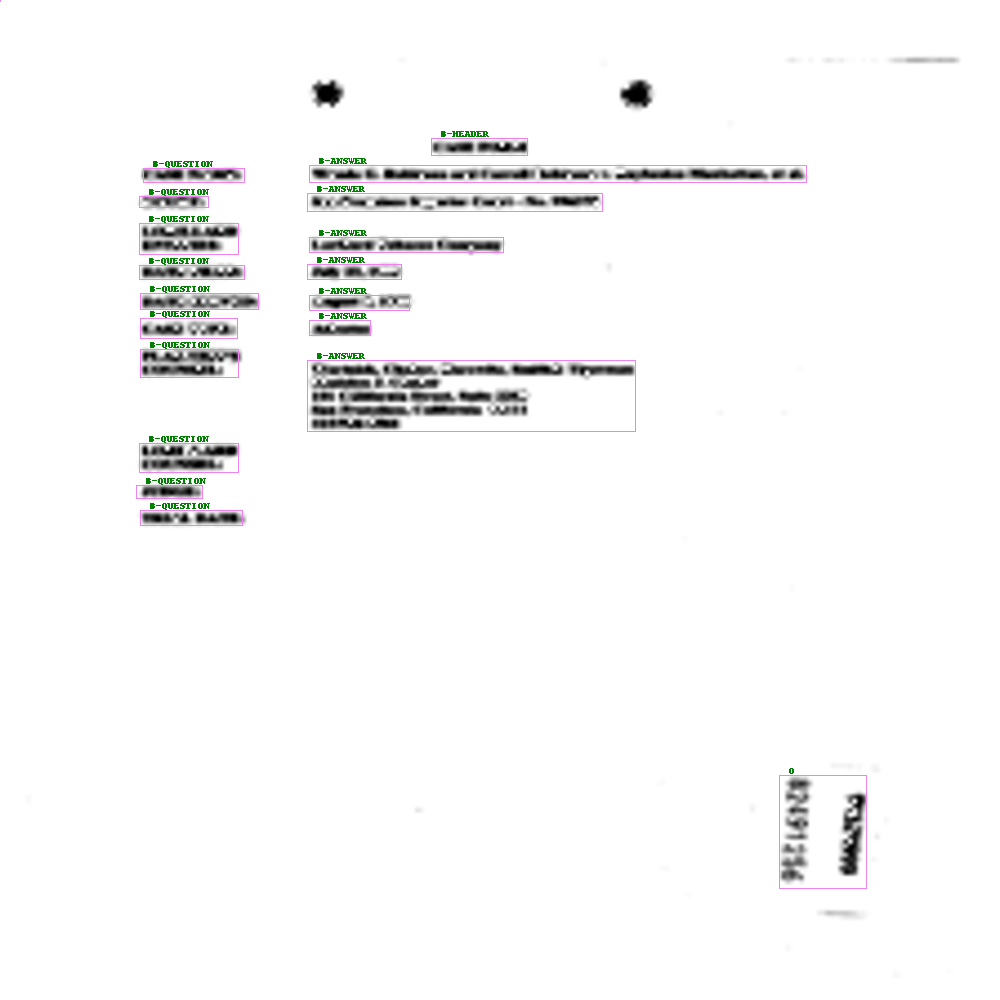

In [25]:
plot_visualization(sample)

### Filtering the tags from which data needs to be extracted

In [26]:
ROI_data = []
unique_data = set() # set to store unique (tag,roi) tuples

# iterate over the ner_tags and bboxes in the sample
for index, value in enumerate(sample["ner_tags"]):
    
    # check if the tag is not 0 (i.e., not a padding token)
    if value != 0:
        data = {"tag": value, "roi": sample["bboxes"][index]}
        
        # check if this (tag,roi) tuple has not been added before
        if (data["tag"], tuple(data["roi"])) not in unique_data and data["roi"][0] != 0:
            ROI_data.append(data)
            unique_data.add((data["tag"], tuple(data["roi"])))

In [27]:
coords = ROI_data
img = cv2.imread("./inference_data/images/82491256.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
new_width = 1000
new_height = 1000
img = cv2.resize(img, (new_width, new_height))
for coord in coords:
    x1, y1, x2, y2 = coord['roi']
    img = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
cv2.imwrite("inference.png", img)

True

### Extracting data from the Selected tags text

In [28]:
lst = []
for coord in coords:
    x1, y1, x2, y2 = coord["roi"]
    roi = img[y1:y2, x1:x2]
    text = pytesseract.image_to_string(roi, lang='eng').replace("\n", "") 
    if len(text) > 0:
        lst.append([id2label1[coord["tag"]], text])

In [29]:
columns = ['tag', 'text']
df = pd.DataFrame(lst, columns=columns)
df = df.drop_duplicates(ignore_index=True)

### Extracted Data

In [30]:
df

tag                                               text
0     ANSWER                                          ‘Asbestos
1     HEADER                                         ‘CASE FORM
2   QUESTION                                         CASE NAME:
3   QUESTION                                       ‘DATE FILED:
4   QUESTION                                       DATE SERVED:
5   QUESTION                                        ‘CASE TYPE:
6   QUESTION                                           COUNSEL:
7   QUESTION                                        TRIAL DATE:
8     ANSWER  Wartnick, Chaber, Harowitz, Smith& TigermanMad...
9     ANSWER                                     August 3, 199%
10    ANSWER                                     July 23, 1998)
11    ANSWER                         ‘Lorillard Tobacco Company
12    ANSWER        ‘San Francisco Superior Court - No. 996378)
13    ANSWER  ‘Wanda G. Robinson and Carroll Robinson v. Ray...

In [31]:
df.to_csv('data.csv', index=False) 